# Time Series Homework

 ## Problem 1

In [1]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bokeh.io import output_notebook, show, export_png
# from bokeh.io import output_file
from bokeh.plotting import figure
from itertools import chain 
from sklearn.metrics import mean_squared_error
import datetime as dt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.ar_model import AutoReg
import pmdarima as pm

import math
import pmdarima as pm
import statsmodels.api as sm
def mean_absolute_percentage_error(y_true, y_pred): 
     return np.mean(np.abs((y_true - y_pred) / y_true)) *100
output_notebook()

Loading BokehJS ...

The data file below contains 10 columns.
* Columns 1-4 give the dates in several redundant formats.
* Column 5 below gives monthly Mauna Loa CO2 concentrations in micro-mol CO2 per mole (ppm), reported on the 2008A SIO manometric mole fraction scale.  This is the standard version of the data most often sought.  The monthly values have been adjusted to 24:00 hours on the 15th of each month.
* Column 6 gives the same data after a seasonal adjustment to remove the quasi-regular seasonal cycle.  The adjustment involves subtracting from the data a 4-harmonic fit with a linear gain factor.
* Column 7 is a smoothed version of the data generated from a stiff cubic spline function plus 4-harmonic functions with linear gain.
* Column 8 is the same smoothed version with the seasonal cycle removed.
* Column 9 is identical to Column 5 except that the missing values from Column 5 have been filled with values from Column 7.
* Column 10 is identical to Column 6 except missing values have been filled with values from Column 8.

Missing values are denoted by -99.99.

> $t_i$ is time at the middle of the $i$th month, measured in fractions of years after Jan 1, 1958. We convert from $i$ (the data index, starting at 0) to $t_i$ as $t_i = \frac{i + 0.5}{12}$
* $+ 0.5$ because $i$ starts at 0 but the first measurement should be 0.5 (halfway through the first month)
* $/ 12$ to get years from months


In [3]:
# Initialize columns of dataframe
cols = [
    "year", "month", "date1", "date2", "co2", "co2_season_adj", "co2_spline_season_adj", "co2_spline", "co2_fill_7", "co2_fill_8"
]
keep_cols = ["year", "month", "co2"]
co2 = (
    pd.read_csv("CO2.csv", skiprows=57, header=None, names=cols)
    .drop(columns=[col for col in cols if col not in keep_cols]) # Only keep column 5 and date columns
    .assign(co2=lambda df: df.co2.replace({-99.99: np.nan})) # -99.99 indicates a homogeneity - replace it with null
    .assign(time=lambda df: (df.index.values + 0.5) / 12) # Convert to time notation that question specifies
)
# View DataFrame to check whether correct table has been generated.
co2.head(10)

,year,month,co2,time
0,1958,1,NaN,0.041667
1,1958,2,NaN,0.125000
2,1958,3,315.70,0.208333
3,1958,4,317.45,0.291667
4,1958,5,317.51,0.375000
5,1958,6,NaN,0.458333
6,1958,7,315.86,0.541667
7,1958,8,314.93,0.625000
8,1958,9,313.21,0.708333
9,1958,10,NaN,0.791667


We see that there are null values, i.e. inhomogeneities, present in the table. Before proceeding we must clean the data. One simple way to do this is to drop all missing values from the table. Other correct methods include forward filling, interpolation etc. 

In [7]:
co2.time.values[3]

0.2916666666666667

In [9]:
print(co2[co2.co2.isnull()]) # View the dates that have invalid data
co2 = co2.dropna() # drop missing values from the dataframe
x = list(chain.from_iterable(co2.time.values[..., None])) 
y = list(chain.from_iterable(co2.co2.values[..., None])) 


     year  month  co2       time
0    1958      1  NaN   0.041667
1    1958      2  NaN   0.125000
5    1958      6  NaN   0.458333
9    1958     10  NaN   0.791667
73   1964      2  NaN   6.125000
74   1964      3  NaN   6.208333
75   1964      4  NaN   6.291667
741  2019     10  NaN  61.791667
742  2019     11  NaN  61.875000
743  2019     12  NaN  61.958333


Split the data into test/training sets with 80 : 20 split. The model will be fit on the training dataset alone and its "goodness" will be tested by finding the prediction errors with respect to the testing data set.  


In [13]:
np.shape(co2.time.values[...,None])

(734, 1)

In [14]:
train_size = int(len(x)*0.8)
gap = 0 # int(len(x)*0.1)
test_size = len(x) - train_size - gap
x_train = x[0:train_size]
y_train = y[0:train_size]
x_test = x[train_size + gap: None]
y_test = y[train_size + gap: None]
co2_test = co2.iloc[train_size + gap: None,:].copy()
co2_train = co2.iloc[0:train_size,:].copy()

Let us first visualize the raw training data

In [16]:
#p = figure(plot_width=400, plot_height=400, title = "C02 Variation with time")
p = figure(width=400, height=400, title = "C02 Variation with time")
p.scatter(x_train,y_train,size=5, line_color="navy", fill_color="orange", fill_alpha=0.5)
p.xaxis.axis_label ='t_i'
p.yaxis.axis_label ='CO2 Concentration'
show(p)

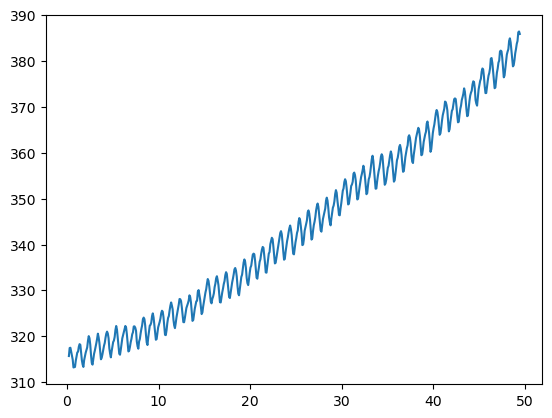

In [17]:
plt.plot(x_train,y_train)

Now, we will fit a linear model to this data set. This can be done use several different functions on Python. Here, the LinearRegression() method from the sklearn packagage is called

In [19]:
model = LinearRegression().fit(np.array(x_train).reshape(-1, 1),y_train)
coefficients = [model.coef_[0],model.intercept_]
print("The linear model is F(t) = " +str(coefficients[0])+"*t + (" +str(coefficients[1])+")")
linear = model.predict(np.array(x_train).reshape(-1, 1))
p = figure(width=400, height=400, title = "C02 Variation with time")
p.scatter(x_train,y_train,size=2, line_color="navy", fill_color="orange", fill_alpha=0.5, legend_label ="Original Data")
p.line(x_train,linear, line_color="orange",line_width=2.5,legend_label ="Linear Fit")
p.xaxis.axis_label ='t_i'
p.yaxis.axis_label ='CO2 Concentration'
show(p)


The linear model is F(t) = 1.4066911494215173*t + (308.9916567323666)


In [21]:
p = figure(width=400, height=400, title = "Residuals (R_linear)")
p.scatter(x_train,y_train - linear,size=2, line_color="red", fill_color="maroon", fill_alpha=0.5, legend_label ="R_linear")
p.yaxis.axis_label ='Residual'
show(p)

We now calculate the RMSE when this model is used to predict test data 

In [22]:
linear_test = model.predict(np.array(x_test).reshape(-1, 1))
p = figure(width=400, height=400, title = "C02 Variation with time")
p.scatter(x_test,y_test,size=2, line_color="navy", fill_color="orange", fill_alpha=0.5, legend_label ="Test Data")
p.line(x_test,linear_test, line_color="orange",line_width=2.5,legend_label ="Linear Model Predictions")
p.xaxis.axis_label ='t_i'
p.yaxis.axis_label ='CO2 Concentration'
p.legend.location = "top_left"
show(p)
rmse_linear = (mean_squared_error(y_test, linear_test,squared=False))
print("RMSE on test data: " + str(rmse_linear))
mape_linear = mean_absolute_percentage_error(y_test, linear_test)
print("MAPE on test data: " + str(mape_linear))

RMSE on test data: 10.641458521874688
MAPE on test data: 2.450454956443147


c:\EngTools\Anaconda3\2023.07\envs\dacourse\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


We now fit a quadratic and cubic model to this data and try to find the residuals and rmse of these models

In [24]:
degree=2
model_2=make_pipeline(PolynomialFeatures(degree),LinearRegression())
model_2.fit(np.array(x_train).reshape(-1, 1),y_train)
quadratic = model_2.predict(np.array(x_train).reshape(-1, 1))

degree=3
model_3=make_pipeline(PolynomialFeatures(degree),LinearRegression())
model_3.fit(np.array(x_train).reshape(-1, 1),y_train)
cubic = model_3.predict(np.array(x_train).reshape(-1, 1))

p = figure(width=400, height=400, title = "C02 Variation with time")
p.scatter(x_train,y_train,size=2, line_color="red", fill_color="orange", fill_alpha=0.5, legend_label ="Original Data")
p.line(x_train,quadratic, line_color="blue",line_width=2.5,legend_label ="Quadratic Fit")
p.line(x_train,cubic, line_color="olive",line_width=2.5,legend_label ="Cubic Fit")
p.xaxis.axis_label ='t_i'
p.yaxis.axis_label ='CO2 Concentration'
p.legend.location = "top_left"
show(p)

coefficients_2 = [model_2.named_steps.linearregression.coef_[-1],model_2.named_steps.linearregression.coef_[-2],model_2.named_steps.linearregression.intercept_]
print("The quadratic model is F(t) = " +str(coefficients_2[0])+"*t^2 + (" +str(coefficients_2[1])+")*t + (" +str(coefficients_2[2])+")")
coefficients_3 = [model_3.named_steps.linearregression.coef_[-1],model_3.named_steps.linearregression.coef_[-2],model_3.named_steps.linearregression.coef_[-3],model_3.named_steps.linearregression.intercept_]
print("The cubic model is F(t) = " +str(coefficients_3[0])+"*t^3 + (" +str(coefficients_3[1])+")*t^2 + ("+str(coefficients_3[2])+")*t + (" + str(coefficients_3[3])+")")

The quadratic model is F(t) = 0.012117499698121086*t^2 + (0.8020970211603167)*t + (314.1005841870842)
The cubic model is F(t) = -0.00011832339739603571*t^3 + (0.020957567397568964)*t^2 + (0.6248954085884497)*t + (314.85852615629074)


In [25]:
p = figure(width=400, height=400, title = "Residuals")
p.scatter(x_train,y_train - quadratic ,size=2, line_color="navy", fill_color="blue", fill_alpha=0.5, legend_label ="R_quadratic")
p.scatter(x_train,y_train - cubic - 3,size=2, line_color="green", fill_color="aquamarine", fill_alpha=0.5, legend_label ="R_cubic")
p.yaxis.axis_label ='Residual'
p.legend.location = "bottom_left"
show(p)


In [26]:
quadratic_test = model_2.predict(np.array(x_test).reshape(-1, 1))
cubic_test = model_3.predict(np.array(x_test).reshape(-1, 1))

p = figure(width=400, height=400, title = "C02 Variation with time")
p.scatter(x_test,y_test,size=2, line_color="navy", fill_color="orange", fill_alpha=0.5, legend_label ="Test Data")
p.line(x_test,quadratic_test, line_color="orange",line_width=2.5,legend_label ="Quadratic Model Predictions")
p.line(x_test,cubic_test, line_color="navy",line_width=2.5,legend_label ="Cubic Model Predictions")
p.xaxis.axis_label ='t_i'
p.yaxis.axis_label ='CO2 Concentration'
p.legend.location = "top_left"
show(p)
rmse_quadratic = (mean_squared_error(y_test, quadratic_test))**0.5
mape_quadratic = mean_absolute_percentage_error(y_test, quadratic_test)
mape_cubic = mean_absolute_percentage_error(y_test, cubic_test)
rmse_cubic = (mean_squared_error(y_test, cubic_test))**0.5
print("The mean squared prediction error of the quadratic model is " + str(rmse_quadratic))
print("The mean absolute percentage error of the quadratic model is " + str(mape_quadratic))
print("\nThe mean squared prediction error of the cubic model is " + str(rmse_cubic))
print("The mean absolute percentage error of the cubic model is " + str(mape_cubic))

The mean squared prediction error of the quadratic model is 2.5013322194898326
The mean absolute percentage error of the quadratic model is 0.5320319129740952

The mean squared prediction error of the cubic model is 4.149370712133284
The mean absolute percentage error of the quadratic model is 0.8483502723894165


We see that the quadratic model performs better than the cubic model and has a lower rmse. Additionally, we see that the residuals plot for both cubic and quadratic are non systematic on trend and very similar in magnitude - i.e. adding an extra degree of complexity hardly improves the model performance. Hence, we take the quadratic model to be representative of the deterministic trend in the timeseries

Next we remove the periodic trend from the data. To do this, we must first remove the deterministic trend from the time series and fit a periodic signal to the remainder. 

In [27]:
co2_train["R_quad"] = y_train - quadratic
co2_train.head(5)

,year,month,co2,time,R_quad
2,1958,3,315.70,0.208333,1.431786
3,1958,4,317.45,0.291667,3.114440
4,1958,5,317.51,0.375000,3.106925
6,1958,7,315.86,0.541667,1.321391
7,1958,8,314.93,0.625000,0.323372


In this problem, it has been assumed that the time period is 12 (which seems to be valid as CO2 concentration is linked to seasonal variation.) First we extract the periodic monthly trend by taking the average of the periodic trend over all months. Next, we interpolate between this values to get a continuous periodic signal

In [29]:
month_mean_res = co2_train.groupby("month").R_quad.mean()
month_continuous = np.linspace(1,12,num = 100, endpoint =True)
periodic= interp1d(month_mean_res.index,month_mean_res.values,kind = 'cubic')
p = figure(width=400, height=400, title = "Periodic Signal")
p.scatter(month_mean_res.index,month_mean_res.values,size=6, line_color="navy", fill_color="green", fill_alpha=0.5,legend_label ='Periodic Values')
p.line(month_continuous,periodic(month_continuous),line_color="navy",line_width =2.5,legend_label ='Periodic Signal')
show(p)
# print(month_mean_res)

Text(0, 0.5, 'CO2 ppm')

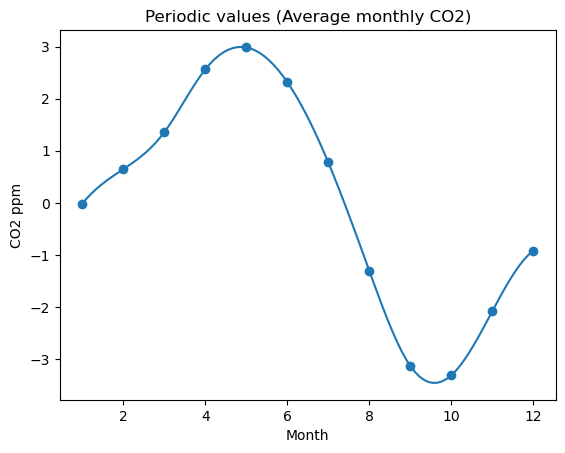

In [36]:
plt.plot(month_continuous,periodic(month_continuous))
plt.scatter(month_mean_res.index,month_mean_res.values)
plt.title('Periodic values (Average monthly CO2)')
plt.xlabel('Month')
plt.ylabel('CO2 ppm')

curve is interpolated (cubic interpolation) to fill inbetween each monthly value.

In [38]:
# plot final fit:  Deterministic fit + Periodic
month_mean_res

month
1    -0.012919
2     0.646407
3     1.355569
4     2.561858
5     2.982891
6     2.316473
7     0.776297
8    -1.301213
9    -3.128074
10   -3.309520
11   -2.081487
12   -0.921507
Name: R_quad, dtype: float64

In [88]:
month_mean_res[1]
nanarr = np.empty((len(co2),1))
nanarr[:] = np.nan
for i in range(1,13):
    val = month_mean_res[i]
    co2_train.loc[co2['month'] == i, 'periodic'] = val
    co2_test.loc[co2['month'] == i, 'periodic'] = val
co2_train['quadratic'] = quadratic
co2_test['quadratic'] = quadratic_test

co2_train['model_y'] = co2_train['quadratic'] + co2_train['periodic']
co2_test['model_y'] = co2_test['quadratic'] + co2_test['periodic']


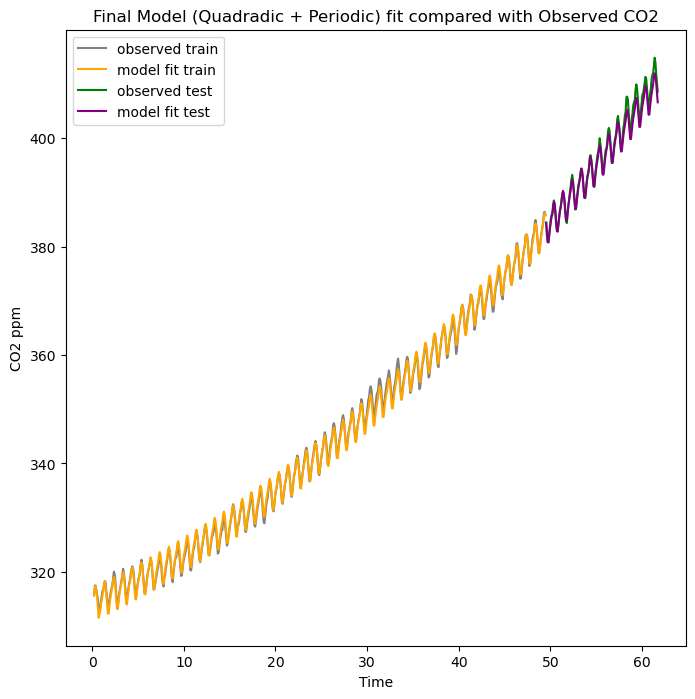

In [84]:
plt.plot(co2_train.time.values, co2_train.co2.values, label='observed train', color='gray')
plt.plot(co2_train.time.values, co2_train.model_y.values, label='model fit train', color='orange')
plt.plot(co2_test.time.values, co2_test.co2.values, label='observed test', color='green')
plt.plot(co2_test.time.values, co2_test.model_y.values, label='model fit test', color='purple')
plt.legend()
plt.title('Final Model (Quadradic + Periodic) fit compared with Observed CO2')
plt.xlabel('Time')
plt.ylabel('CO2 ppm')
fig = plt.gcf()
fig.set_size_inches(8,8)

In [87]:
rmse_finalmodel_test = (mean_squared_error(y_test, co2_test.model_y.values))**0.5
mape_finalmodel_test = mean_absolute_percentage_error(y_test, co2_test.model_y.values)
print(f'rmse final model test {rmse_finalmodel_test}')
print(f'mape final model test {mape_finalmodel_test}')
print('compared to')

print("The mean squared prediction error of the quadratic model is " + str(rmse_quadratic))
print("The mean absolute percentage error of the quadratic model is " + str(mape_quadratic))

rmse final model test 1.1493602690795508
mape final model test 0.20859165947993008
compared to
The mean squared prediction error of the quadratic model is 1.1493602690795508
The mean absolute percentage error of the quadratic model is 0.5320319129740952


Report Problem 1.3:
RMSE not much better. MAPE is an improvement.

In [89]:
co2_combined = pd.concat([co2_train, co2_test], axis=0)

min   -2.977710
max    1.738734
Name: residuals, dtype: float64
min    314.268214
max    409.739105
Name: quadratic, dtype: float64
min   -3.309520
max    2.982891
Name: periodic, dtype: float64


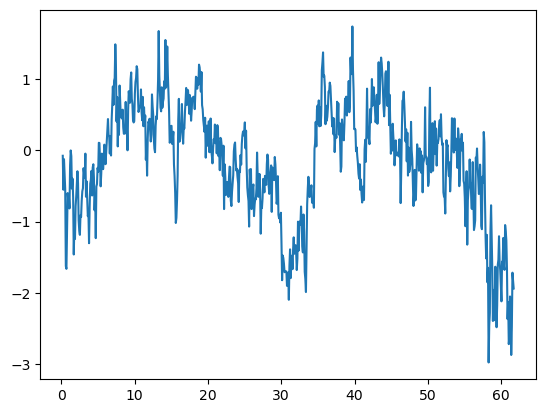

In [96]:
# plt.plot(co2_combined.time.values,co2_combined.model_y.values)
co2_combined['residuals'] = co2_combined.model_y - co2_combined.co2
plt.plot(co2_combined.time.values, co2_combined.residuals)

print(co2_combined['residuals'].agg(['min', 'max']))
print(co2_combined['quadratic'].agg(['min', 'max']))
print(co2_combined['periodic'].agg(['min', 'max']))

Ratio of range of values of Deterministic (Periodic) was significantly larger than range of Periodic values. Range of Periodic to residuals was not significantly larger.  So the decomposition of the Deterministic componenet was meaningful. The further decomposition of Periodic was not meaningful since residuals range was similar to the Periodic range.

In [98]:
a=co2_combined['residuals'].agg(['min', 'max'])

In [102]:
a['min']

-2.9777103446027695